导包

In [1]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
# %matplotlib inline
# ## 模型预测的
# !pip install scikit-learn
# !pip install lightgbm
# !pip install xgboost
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA
import lightgbm as lgb
import xgboost as xgb
## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
# !pip install jieba
import jieba

读取数据集

In [2]:
train_insensitiveness_path = '题目B基于文本内容的敏感信息识别/data/train_insensitiveness.csv'
train_sensitiveness_path = '题目B基于文本内容的敏感信息识别/data/train_sensitiveness.csv'
test_path = '题目B基于文本内容的敏感信息识别/data/test.csv'

# 读取违规数据
with open(train_insensitiveness_path, 'r', encoding='ANSI',errors='ignore') as insensitiveness_file:
    insensitiveness_data = pd.read_csv(insensitiveness_file)

# 读取非违规数据
with open(train_sensitiveness_path, 'r', encoding='ANSI',errors='ignore') as sensitiveness_file:
    sensitiveness_data = pd.read_csv(sensitiveness_file)

# 读取测试数据
with open(test_path, 'r', encoding='ANSI',errors='ignore') as test_file:
    test_data = pd.read_csv(test_file)

# 合并违规与非违规数据
merged_data = pd.concat([sensitiveness_data, insensitiveness_data], ignore_index=True)

#保存合并数据到新文件
output_path = 'merged_data.csv'
with open(output_path, 'w', encoding='utf-8', newline='') as output_file:
    merged_data.to_csv(output_file, index=False)
# 保存非违规数据到新文件
output_path = 'sensitiveness_n.csv'
with open(output_path, 'w', encoding='utf-8', newline='') as output_file:
    sensitiveness_data.to_csv(output_file, index=False)
# 保存违规数据到新文件   
output_path = 'insensitiveness_n.csv'
with open(output_path, 'w', encoding='utf-8', newline='') as output_file:
    insensitiveness_data.to_csv(output_file, index=False)
# 保存测试数据到新文件
output_path = 'test_n.csv'
with open(output_path, 'w', encoding='utf-8', newline='') as output_file:
    test_data.to_csv(output_file, index=False)

In [3]:
merged_data.head()

,0,label
0,也是，想想物流爆仓等半个月和打砸抢烧丧尸围城一般冒着被黑人胖大妈一屁股坐死的风险半夜2点去门...,0
1,说这些。四川人是不是只有喝西北风才健康啊。抛开剂量谈毒性都是垃圾,0
2,男女大脑差异的的确确是研究证明了啊，就好像黑人短跑比白人快也是事实一样。过度政治正确真的没必...,0
3,但是也听过她的一些料。网上那个浙江卫视打压她是真的。因为毕竟是浙江卫视耗费人力资源捧红了她，...,0
4,估计就是做的不好吃，就是相当于拌饭包起来，不能说多好吃的东西，但是一般恶心不至于。可能主要是...,0


0是违规，1是非违规

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\admin\AppData\Local\Temp\jieba.cache
Loading model cost 0.666 seconds.
Prefix dict has been built successfully.


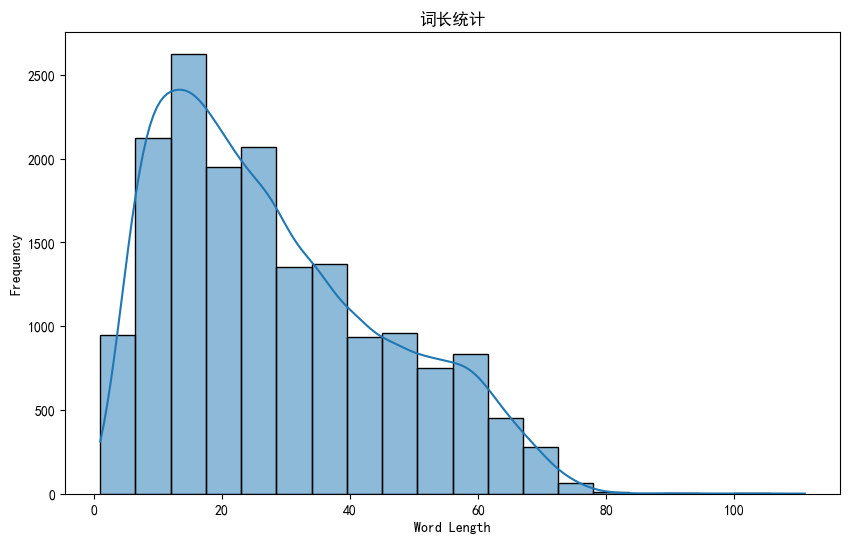

In [4]:
# -*- coding: utf-8 -*-
import jieba
import re
import matplotlib.pyplot as plt
import seaborn as sns

# 设置字体为中文
plt.rcParams['font.sans-serif'] = ['SimHei']

# 定义从右向左分词函数
def cut_text_right_to_left(text):
    # 使用正则表达式去除标点符号
    text_no_punct = re.sub(r'[^\w\s]', '', text)
    # 使用逆向最大分词法
    words = jieba.lcut(text_no_punct, cut_all=False, HMM=False)
    return ' '.join([word for word in words ])

# 分析文本内容的词长
merged_data['word_length'] = merged_data['0'].apply(lambda x: len(str(cut_text_right_to_left(x)).split()))

# 绘制词长统计图
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['word_length'], bins=20, kde=True)
plt.title('词长统计')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()


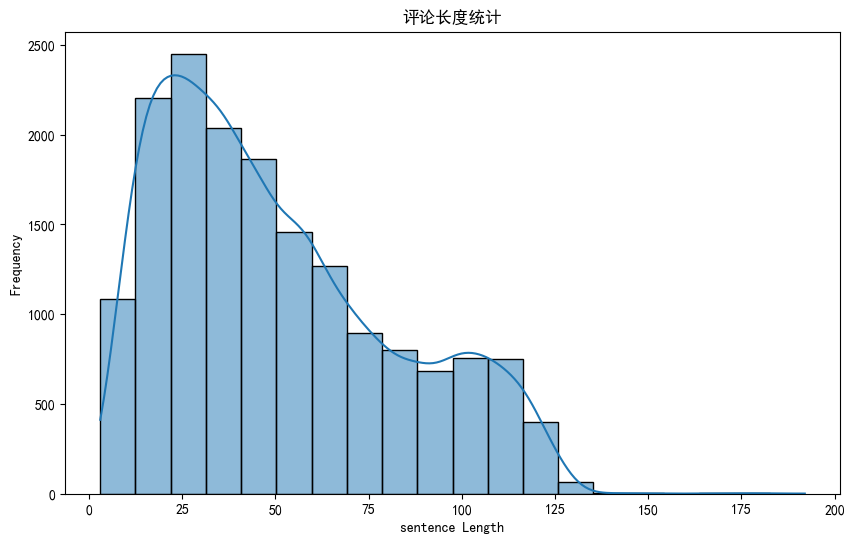

In [5]:
#-*- coding: utf-8 -*-
plt.rcParams['font.sans-serif'] = ['SimHei']

# 分析文本内容的词长
merged_data['word_length'] = merged_data['0'].apply(lambda x: len(str(x)))

# 绘制词长统计图
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['word_length'], bins=20, kde=True)
plt.title('评论长度统计')
plt.xlabel('sentence Length')
plt.ylabel('Frequency')
plt.show()

对badwords进行base64解码

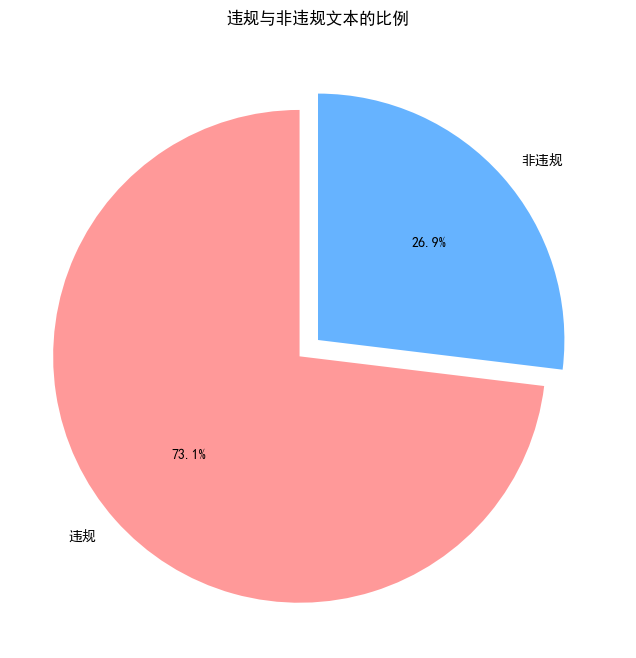

In [6]:
# 计算违规信息和非违规信息数量
violation_count = merged_data[merged_data['label'] == 0].shape[0]
non_violation_count = merged_data[merged_data['label'] == 1].shape[0]

# 绘制占比饼图
labels = ['违规', '非违规']
sizes = [violation_count, non_violation_count]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('违规与非违规文本的比例')
plt.show()

In [7]:
# 定义最大逆向分词函数，只保留长度大于等于2的词
def cut_text_max_reverse(text):
    # 使用正则表达式去除标点符号
    text_no_punct = re.sub(r'[^\w\s]', '', text)
    
    # 从句子的最后一个字符开始逆向扫描整个句子，找到最长的词
    words = jieba.lcut(text_no_punct, cut_all=False, HMM=False)  # 使用lcut方法进行最大逆向分词
    
    return ' '.join([word for word in words ])
    # 只保留长度大于等于2的词

违规词语数量: 41191
违规词占比: 8.73%


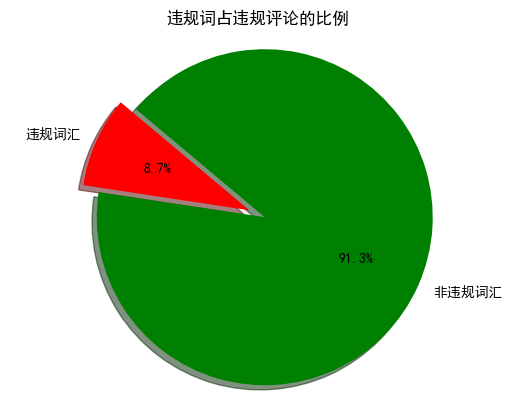

In [8]:
import string
import matplotlib.pyplot as plt
# 停用词文件路径
stop_words_path = 'stopwords\\baidu_stopwords.txt'

# 读取停用词文件
with open(stop_words_path, 'r', encoding='utf-8') as stop_words_file:
    stop_words = set([line.strip() for line in stop_words_file])

# 合并所有文本内容
all_text = ' '.join(merged_data['0'].astype(str))

# 去除标点符号
translator = str.maketrans("", "", string.punctuation)
all_text_no_punct = all_text.translate(translator)

# 分词并去除停用词
all_text_processed = cut_text_max_reverse(all_text_no_punct)

# 读取违规词列表
with open('./badwords/banned6.txt', 'r', encoding='utf-8') as banned_words_file:
    banned_words = set([line.strip() for line in banned_words_file])

# 统计违规词数量
violations_count = sum(1 for word in all_text_processed.split() if word in banned_words)

# 计算百分比
total_words_count = len(all_text_processed.split())
percentage_violations = (violations_count / total_words_count) * 100

# 输出结果
print(f'违规词语数量: {violations_count}')
print(f'违规词占比: {percentage_violations:.2f}%')

# 可视化
labels = ['违规词汇', '非违规词汇']
sizes = [violations_count, total_words_count - violations_count]
colors = ['red', 'green']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('违规词占违规评论的比例')
plt.show()


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


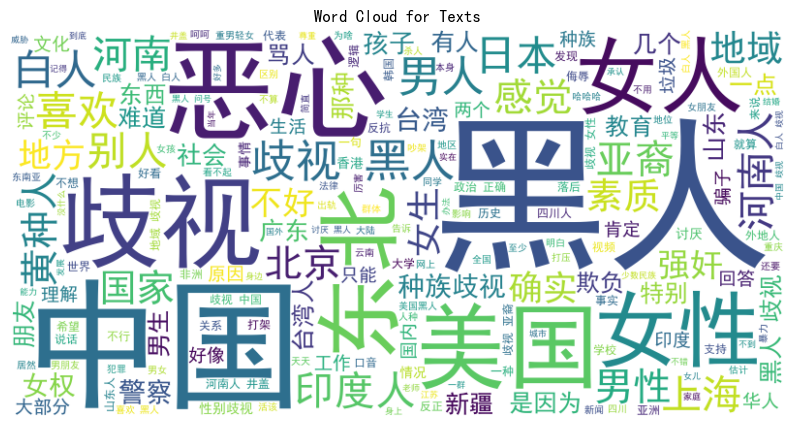

违规文本中前10单词（不包括标点符号和停用词）:
黑人     4794
歧视     3602
中国     2309
恶心     1522
女性     1149
美国     1070
男人      970
白人      937
女人      911
河南人     888
Name: count, dtype: int64


In [9]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import string
import re

# 字体文件路径
font_path = 'SimHei.ttf'
# 停用词文件路径
stop_words_path = 'stopwords\\baidu_stopwords.txt'

# 定义最大逆向分词函数，只保留长度大于等于2的词
def cut_text_max_reverse(text):
    # 使用正则表达式去除标点符号
    text_no_punct = re.sub(r'[^\w\s]', '', text)
    
    # 从句子的最后一个字符开始逆向扫描整个句子，找到最长的词
    words = jieba.lcut(text_no_punct, cut_all=False, HMM=False)  # 使用lcut方法进行最大逆向分词
    # 只保留长度大于等于2的词
    return ' '.join([word for word in words if word not in stop_words and len(word) >= 2])
    

# 读取停用词文件
with open(stop_words_path, 'r', encoding='utf-8') as stop_words_file:
    stop_words = set([line.strip() for line in stop_words_file])

# 合并所有文本内容
all_text = ' '.join(merged_data['0'].astype(str))

# 去除标点符号
translator = str.maketrans("", "", string.punctuation)
all_text_no_punct = all_text.translate(translator)

# 分词并去除停用词
all_text_processed = cut_text_max_reverse(all_text_no_punct)

# 制作词云图
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(all_text_processed)

# 显示词云图
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Texts')
plt.show()

# 统计违规信息中出现次数最多的 10 个词（排除标点和停用词）
violation_text = merged_data[merged_data['label'] == 0]['0']
violation_text_no_punct = ' '.join(violation_text).translate(translator)
violation_text_processed = cut_text_max_reverse(violation_text_no_punct)

violation_word_counts = pd.Series(violation_text_processed.split()).value_counts()
top_10_violation_words = violation_word_counts.head(10)
print('违规文本中前10单词（不包括标点符号和停用词）:')
print(top_10_violation_words)

# # 保存到文件
# top_100_violation_words = violation_word_counts.head(100)
# with open('top_100_violation_words.txt', 'w', encoding='utf-8') as file:
#     file.write('\n'.join(top_100_violation_words.index.astype(str)))

主题预测

In [10]:
from gensim import corpora, models
import pandas as pd
from gensim.models.ldamodel import LdaModel

# 读取merged_data.csv文件
merged_data = pd.read_csv('sensitiveness_n.csv')

# # 定义从右向左分词函数，只保留长度大于等于2的词
# def cut_text_right_to_left(text):
#     # 使用正则表达式去除标点符号
#     text_no_punct = re.sub(r'[^\w\s]', '', text)
#     # 使用结巴分词进行从右向左分词
#     words = jieba.cut_for_search(text_no_punct)
#     # 只保留长度大于等于2的词
#     return [word for word in words if word not in stop_words and len(word) >= 2]

# 分词并去除停用词
documents = [cut_text_max_reverse(text) for text in merged_data['0']]
# print(documents)
# tt = [' '.join(jieba.lcut(text)).lower() for text in documents]

In [11]:
# from gensim.models.ldamodel import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# from gensim import corpora, models
# import jieba
# import re

# # 读取数据
# merged_data = pd.read_csv('sensitiveness_n.csv')

# # 停用词文件路径
# stop_words_path = 'stopwords\\baidu_stopwords.txt'

# # 读取停用词文件
# with open(stop_words_path, 'r', encoding='utf-8') as stop_words_file:
#     stop_words = set([line.strip() for line in stop_words_file])

# # 定义从右向左分词函数，只保留长度大于等于2的词
# def cut_text_right_to_left(text):
#     # 使用正则表达式去除标点符号
#     text_no_punct = re.sub(r'[^\w\s]', '', text)
#     # 使用结巴分词进行从右向左分词
#     words = jieba.cut_for_search(text_no_punct)
#     # 只保留长度大于等于2的词
#     return [word for word in words if word not in stop_words and len(word) >= 2]

# # 分词并去除停用词
# documents = [cut_text_right_to_left(text) for text in merged_data['0']]

# # 创建词袋模型
# dictionary = corpora.Dictionary(documents)
# corpus = [dictionary.doc2bow(tokens) for tokens in documents]

# #计算困惑度
# def perplexity(num_topics):
#     ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30)
#     print(ldamodel.print_topics(num_topics=num_topics, num_words=15))
#     # print(ldamodel.log_perplexity(corpus))
#     return ldamodel.log_perplexity(corpus)
# #计算coherence
# def coherence(num_topics):
#     ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=100,random_state = 1)
#     print(ldamodel.print_topics(num_topics=num_topics, num_words=10))
#     ldacm = CoherenceModel(model=ldamodel, texts=documents, dictionary=dictionary, coherence='c_v')
#     # print(ldacm.get_coherence())
#     return ldacm.get_coherence()


# x = range(1,15)
# # z = [perplexity(i) for i in x]  #如果想用困惑度就选这个
# y = [coherence(i) for i in x]
# plt.plot(x, y)
# plt.xlabel('主题数目')
# plt.ylabel('coherence大小')
# plt.rcParams['font.sans-serif']=['SimHei']
# matplotlib.rcParams['axes.unicode_minus']=False
# plt.title('主题-coherence变化情况')
# plt.show()

In [12]:
import pandas as pd
from gensim import corpora, models
import jieba
import re

# 读取数据
merged_data = pd.read_csv('sensitiveness_n.csv')

# 停用词文件路径
stop_words_path = 'stopwords\\baidu_stopwords.txt'

# 读取停用词文件
with open(stop_words_path, 'r', encoding='utf-8') as stop_words_file:
    stop_words = set([line.strip() for line in stop_words_file])

# 定义从右向左分词函数，只保留长度大于等于2的词
def cut_text_right_to_left(text):
    # 使用正则表达式去除标点符号
    text_no_punct = re.sub(r'[^\w\s]', '', text)
    # 使用结巴分词进行从右向左分词
    words = jieba.cut_for_search(text_no_punct)
    # 只保留长度大于等于2的词
    return [word for word in words if word not in stop_words and len(word) >= 2]

# 分词并去除停用词
documents = [cut_text_right_to_left(text) for text in merged_data['0']]

# 创建词袋模型
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(tokens) for tokens in documents]

# 训练LDA模型
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, 
                            num_topics=4, alpha="auto", eta='auto', passes=500, random_state=21)

# 预测主题并将标签添加到DataFrame
predicted_topics = [lda_model.get_document_topics(tokens) for tokens in corpus]
merged_data['predicted_topic'] = [max(topic, key=lambda x: x[1])[0] for topic in predicted_topics]
merged_data['topic_keywords'] = [lda_model.print_topic(topic, topn=5) for topic in merged_data['predicted_topic']]

# 打印每个主题的前50个特征词
for i in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(i, topn=10)
    print(f"主题 {i} 的前10个特征词：")
    for term, weight in topic_terms:
        print(f"{term}: {weight}")
    print("\n")

# 将DataFrame写回CSV文件
merged_data.to_csv('sensitiveness_with_topics.csv', index=False)


主题 0 的前10个特征词：
黑人: 0.05689790099859238
歧视: 0.04576136916875839
中国: 0.026123682036995888
河南: 0.01746199280023575
美国: 0.013865131884813309
南人: 0.010162276215851307
白人: 0.010138272307813168
种族: 0.010046659968793392
河南人: 0.009902507066726685
亚裔: 0.007007990963757038


主题 1 的前10个特征词：
女性: 0.03051481395959854
男性: 0.01823381893336773
歧视: 0.012187783606350422
强奸: 0.009515303187072277
女生: 0.009094838052988052
性别: 0.00825237762182951
恶心: 0.007810783572494984
女权: 0.007549097295850515
男生: 0.0068299234844744205
性别歧视: 0.005805386230349541


主题 2 的前10个特征词：
女人: 0.027349038049578667
男人: 0.02524847723543644
恶心: 0.019063247367739677
印度: 0.011932016350328922
印度人: 0.007266029715538025
孩子: 0.005380909889936447
出轨: 0.004648032132536173
喜欢: 0.004515656270086765
强奸: 0.00353563972748816
垃圾: 0.0032530557364225388


主题 3 的前10个特征词：
东北: 0.020507365465164185
上海: 0.01670839451253414
北京: 0.010919664986431599
山东: 0.010901610367000103
恶心: 0.010125506669282913
地域: 0.010113607160747051
外地: 0.00975678488612175
外地人: 0.008508

0:种族歧视 1：性别歧视 2：男女关系 3：地域歧视

In [13]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(data, 'topic10.html')

In [14]:
from IPython.display import HTML

# 读取HTML文件内容
with open('topic10.html', 'r', encoding='utf-8') as file:
    html_content = file.read()

HTML(html_content)

导入预训练模型

In [15]:
from transformers import BertTokenizer, ErnieModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# 读取数据
data_path = 'merged_data.csv'
data = pd.read_csv(data_path)
# 打乱数据
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# 分割数据集为训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# train_data = train_data.head(10)
# test_data = test_data.head(10)

# 读取预训练的 ERNIE 模型
ernie_model_name = 'nghuyong/ernie-1.0-base-zh'
tokenizer = BertTokenizer.from_pretrained(ernie_model_name)
ernie_model = ErnieModel.from_pretrained(ernie_model_name)

C:\Users\admin\.conda\envs\deeplearning\lib\site-packages\h5py\__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
C:\Users\admin\.conda\envs\deeplearning\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


预训练、分类

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 设置随机种子
seed = 12
torch.manual_seed(seed)
np.random.seed(seed)

# 在GPU上运行时，确保设定cuda的随机种子
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# # 使得每次运行结果都是确定性的
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


# 对文本进行分词和编码
train_texts = train_data['0'].tolist()
train_labels = train_data['label'].tolist()

test_texts = test_data['0'].tolist()
test_labels = test_data['label'].tolist()

train_encodings = tokenizer(train_texts, max_length=128, padding='max_length', truncation=True)
test_encodings = tokenizer(test_texts, max_length=128, padding='max_length', truncation=True)

# 提取输入和输出
train_inputs = torch.tensor(train_encodings['input_ids'])
train_labels = torch.tensor(train_labels)

test_inputs = torch.tensor(test_encodings['input_ids'])
test_labels = torch.tensor(test_labels)

# 构建模型
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout_rate=0.5):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(embedding_dim, hidden_size, kernel_size=3)
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(p=dropout_rate)  # 添加dropout层
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Change the shape for Conv1D
        x = self.conv1d(x)
        x = self.pooling(x).squeeze(2)
        x = self.dropout(x)  # 在池化层后加入dropout
        x = torch.sigmoid(self.fc(x))
        return x

# 定义模型和优化器
vocab_size = tokenizer.vocab_size
embedding_dim = 768
# embedding_dim = 1024
hidden_size = 128
dropout_rate = 0.5  # 你可以调整dropout的比例

model = TextClassifier(vocab_size, embedding_dim, hidden_size, dropout_rate)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# 转换为 DataLoader
train_dataset = TensorDataset(train_inputs, train_labels.float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 打印模型参数
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

# 训练模型
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # 计算训练过程中的准确率
        predictions = (outputs > 0.5).float()
        correct = (predictions == labels.unsqueeze(1)).float().sum()
        total_correct += correct.item()
        total_samples += labels.size(0)
        total_loss += loss.item()

    # 计算平均损失和准确率
    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

# 评估模型
model.eval()
with torch.no_grad():
    test_outputs = model(test_inputs)
    test_outputs = test_outputs.squeeze(1)  # Remove the singleton dimension
    test_loss = criterion(test_outputs, test_labels.float())
    test_accuracy = ((test_outputs > 0.5).float() == test_labels.float()).float().mean().item()

# 打印评估结果
print('Test Loss:', test_loss.item())
print('Test Accuracy:', test_accuracy)


embedding.weight: torch.Size([17964, 768])
conv1d.weight: torch.Size([128, 768, 3])
conv1d.bias: torch.Size([128])
fc.weight: torch.Size([1, 128])
fc.bias: torch.Size([1])
Epoch [1/20], Loss: 0.4557, Accuracy: 0.7954
Epoch [2/20], Loss: 0.3080, Accuracy: 0.8707
Epoch [3/20], Loss: 0.2475, Accuracy: 0.9010
Epoch [4/20], Loss: 0.2071, Accuracy: 0.9179
Epoch [5/20], Loss: 0.1710, Accuracy: 0.9375
Epoch [6/20], Loss: 0.1372, Accuracy: 0.9484
Epoch [7/20], Loss: 0.1095, Accuracy: 0.9615
Epoch [8/20], Loss: 0.0911, Accuracy: 0.9663
Epoch [9/20], Loss: 0.0750, Accuracy: 0.9731
Epoch [10/20], Loss: 0.0604, Accuracy: 0.9788
Epoch [11/20], Loss: 0.0500, Accuracy: 0.9812
Epoch [12/20], Loss: 0.0418, Accuracy: 0.9853
Epoch [13/20], Loss: 0.0368, Accuracy: 0.9869
Epoch [14/20], Loss: 0.0355, Accuracy: 0.9872
Epoch [15/20], Loss: 0.0353, Accuracy: 0.9886
Epoch [16/20], Loss: 0.0360, Accuracy: 0.9868
Epoch [17/20], Loss: 0.0258, Accuracy: 0.9903
Epoch [18/20], Loss: 0.0298, Accuracy: 0.9892
Epoch [19

In [17]:
# 保存模型
torch.save(model.state_dict(), 'text_classifier_model.pth')

In [18]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

# 读取测试数据
test_data = pd.read_csv('test_n.csv')

# 对测试文本进行分词和编码
test_texts = test_data['0'].tolist()
test_encodings = tokenizer(test_texts, max_length=128, padding='max_length', truncation=True)

# 提取输入
test_inputs = torch.tensor(test_encodings['input_ids'])

# 构建 DataLoader
test_dataset = TensorDataset(test_inputs)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 加载模型
model = TextClassifier(vocab_size, embedding_dim, hidden_size)
model.load_state_dict(torch.load('text_classifier_model.pth'))
model.eval()

# 预测
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        outputs = model(inputs[0])
        predictions.extend(outputs.cpu().numpy())

# 假设 predictions 是包含概率值的列表，你可以根据需要进行后续处理
# 例如，将概率值大于0.5的标记为类别1，否则为类别0
threshold = 0.5
predicted_labels = [1 if prob > threshold else 0 for prob in predictions]

# 将预测结果保存到 DataFrame 中
test_data['predicted_label'] = predicted_labels
test_data.to_csv('test_predictions.csv', index=False)

In [19]:
import pandas as pd

def csv_to_xlsx_pd():
    # 读取 CSV 文件
    csv = pd.read_csv('test_predictions.csv', encoding='utf-8')

    # 将 'predicted_label' 列重命名为 'label'
    csv = csv.rename(columns={'predicted_label': 'label'})

    # 将 DataFrame 写入 Excel 文件
    csv.to_excel('test.xlsx', sheet_name='data', index=False)

if __name__ == '__main__':
    csv_to_xlsx_pd()

In [22]:
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score

# 读取数据
data_path = 'merged_data.csv'
data = pd.read_csv(data_path)
# 打乱数据
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# 分割数据集为训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 加载预训练的 ERNIE 模型和分词器
tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-1.0-base-zh")
ernie_model = AutoModel.from_pretrained("nghuyong/ernie-1.0-base-zh")

# 假设 train_data 和 test_data 是已经加载的数据框，包含列 '0' 和 'label'
train_texts = train_data['0'].tolist()
train_labels = train_data['label'].tolist()

test_texts = test_data['0'].tolist()
test_labels = test_data['label'].tolist()

# 处理编码和截断
def preprocess_data(texts, tokenizer, max_length=128):
    encodings = tokenizer(texts, max_length=max_length, padding='max_length', truncation=True)
    return torch.tensor(encodings['input_ids'])

train_inputs = preprocess_data(train_texts, tokenizer)
test_inputs = preprocess_data(test_texts, tokenizer)

train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# 构建模型
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout_rate=0.5):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d_1 = nn.Conv1d(embedding_dim, hidden_size, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.conv1d_2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1d_1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv1d_2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pooling(x).squeeze(2)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc(x))
        return x

# 定义模型和优化器
vocab_size = tokenizer.vocab_size
embedding_dim = 768
hidden_size = 128
dropout_rate = 0.5

model = TextClassifier(vocab_size, embedding_dim, hidden_size, dropout_rate)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# 转换为 DataLoader
train_dataset = TensorDataset(train_inputs, train_labels.float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 打印模型参数
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

# 训练模型
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # 计算训练过程中的准确率
        predictions = (outputs > 0.5).float()
        correct = (predictions == labels.unsqueeze(1)).float().sum()
        total_correct += correct.item()
        total_samples += labels.size(0)
        total_loss += loss.item()

    scheduler.step()  # 更新学习率

    # 计算平均损失和准确率
    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

# 评估模型
model.eval()
with torch.no_grad():
    test_outputs = model(test_inputs)
    test_outputs = test_outputs.squeeze(1)  # Remove the singleton dimension
    test_loss = criterion(test_outputs, test_labels.float())
    test_accuracy = ((test_outputs > 0.5).float() == test_labels.float()).float().mean().item()
    test_predictions = (test_outputs > 0.5).float()
    f1 = f1_score(test_labels, test_predictions)
    recall = recall_score(test_labels, test_predictions)

# 打印评估结果
print('Test Loss:', test_loss.item())
print('Test Accuracy:', test_accuracy)
print('F1 Score:', f1)
print('Recall:', recall)


embedding.weight: torch.Size([17964, 768])
conv1d_1.weight: torch.Size([128, 768, 3])
conv1d_1.bias: torch.Size([128])
bn1.weight: torch.Size([128])
bn1.bias: torch.Size([128])
conv1d_2.weight: torch.Size([128, 128, 3])
conv1d_2.bias: torch.Size([128])
bn2.weight: torch.Size([128])
bn2.bias: torch.Size([128])
fc.weight: torch.Size([1, 128])
fc.bias: torch.Size([1])
Epoch [1/10], Loss: 0.4688, Accuracy: 0.7705
Epoch [2/10], Loss: 0.3431, Accuracy: 0.8538
Epoch [3/10], Loss: 0.2790, Accuracy: 0.8913
Epoch [4/10], Loss: 0.2572, Accuracy: 0.9014
Epoch [5/10], Loss: 0.2477, Accuracy: 0.9066
Epoch [6/10], Loss: 0.2367, Accuracy: 0.9089
Epoch [7/10], Loss: 0.2361, Accuracy: 0.9105
Epoch [8/10], Loss: 0.2342, Accuracy: 0.9112
Epoch [9/10], Loss: 0.2375, Accuracy: 0.9098
Epoch [10/10], Loss: 0.2350, Accuracy: 0.9113
Test Loss: 0.26633602380752563
Test Accuracy: 0.8981665968894958
F1 Score: 0.799214145383104
Recall: 0.773972602739726


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import pandas as pd

# 读取数据
data_path = 'merged_data.csv'
data = pd.read_csv(data_path)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# 分割数据集为训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 加载预训练的 ERNIE 模型和分词器
tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-3.0-ba-zh")
ernie_model = AutoModel.from_pretrained("nghuyong/ernie-3.0-mini-zh")

# 假设 train_data 和 test_data 是已经加载的数据框，包含列 '0' 和 'label'
train_texts = train_data['0'].tolist()
train_labels = train_data['label'].tolist()

test_texts = test_data['0'].tolist()
test_labels = test_data['label'].tolist()

# 处理编码和截断
def preprocess_data(texts, tokenizer, max_length=128):
    encodings = tokenizer(texts, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
    return encodings['input_ids'], encodings['attention_mask']

train_inputs, train_masks = preprocess_data(train_texts, tokenizer)
test_inputs, test_masks = preprocess_data(test_texts, tokenizer)

# 确保第一个时间步的掩码值为 1
train_masks[:, 0] = 1
test_masks[:, 0] = 1

# 将标签扩展为与输入相同的形状
train_labels = torch.tensor(train_labels).unsqueeze(1).expand(-1, train_inputs.size(1))
test_labels = torch.tensor(test_labels).unsqueeze(1).expand(-1, test_inputs.size(1))

# CRF层的实现
from torchcrf import CRF

# 构建模型
class TextClassifier(nn.Module):
    def __init__(self, ernie_model, hidden_size, num_labels, dropout_rate=0.5):
        super(TextClassifier, self).__init__()
        self.ernie_model = ernie_model
        self.lstm = nn.LSTM(ernie_model.config.hidden_size, hidden_size, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_labels)
        self.crf = CRF(num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad():
            outputs = self.ernie_model(input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        lstm_output, _ = self.lstm(sequence_output)
        lstm_output = self.dropout(lstm_output)
        emissions = self.fc(lstm_output)
        
        if labels is not None:
            loss = -self.crf(emissions, labels, mask=attention_mask.byte(), reduction='mean')
            return loss
        else:
            prediction = self.crf.decode(emissions, mask=attention_mask.byte())
            return prediction

# 定义模型和优化器
hidden_size = 128
num_labels = 2  # 假设有两个标签
dropout_rate = 0.5

model = TextClassifier(ernie_model, hidden_size, num_labels, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# 转换为 DataLoader
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 训练模型
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for inputs, masks, labels in train_loader:
        optimizer.zero_grad()
        loss = model(inputs, attention_mask=masks, labels=labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()  # 更新学习率

    # 计算平均损失
    average_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}')

# 评估模型
model.eval()
with torch.no_grad():
    test_inputs = test_inputs.to(torch.long)
    test_masks = test_masks.to(torch.long)
    test_labels = test_labels.to(torch.long)
    
    predictions = model(test_inputs, attention_mask=test_masks)
    correct = 0
    total = 0
    for prediction, label in zip(predictions, test_labels):
        correct += (torch.tensor(prediction) == label).sum().item()
        total += len(label)
    
    test_accuracy = correct / total

# 打印评估结果
print('Test Accuracy:', test_accuracy)
